In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten, Input, Attention
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber
from xgboost import XGBRegressor
from keras.regularizers import l2, l1
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import shap
import seaborn as sns

### UTILITY FUNCTIONS

In [57]:
IBM_BLUE = "#648FFF"
IBM_PURPLE = "#785EF0"
IBM_PINK = "#DC267F"
IBM_ORANGE = "#FE6100"
IBM_YELLOW = "#FFB000"

In [3]:
### IBWC file reader
def clean_IBWC_csvs(path,dropcols='End of Interval (UTC-06:00)',value_current="Average (TCM)",
                    value_target="storage",datecol="Start of Interval (UTC-06:00)",start_date='1962-01-01',end_date='2023-12-31'):
    """
    Cleans a csv dataset from the IBWC
    """
    dat = pd.read_csv(path,skiprows=4,skipfooter=1,engine='python')
    try:
        dat.drop(dropcols, inplace=True, axis='columns')
    except:
        print(f'No columns to drop, continuing...')
    dat[datecol] = pd.to_datetime(dat[datecol])
    dat.rename(columns={datecol:"date", value_current:value_target}, inplace=True)
    dat["date"] = pd.to_datetime(dat["date"])
    dat = dat[(dat['date'] >= start_date) & (dat['date'] <= end_date)]
    return dat

In [4]:
def process_data(df, laboq_levels, target_column='flow', lookback_period=100, lag_dict=None, debug=0, trainyrs=5, valyrs=3):
    if debug < 1:
        print("Initial Data:")
        print(df.head())

    data = df.copy()

    # Ensure the date column is datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Set default lag_dict if not provided
    if lag_dict is None:
        lag_dict = {
            "flow": 9,
            "storage": 2,
            "total": 7,
            "tc": 7
        }

    # Add lagged features dynamically based on the specified lag_dict
    for var in lag_dict.keys():
        lag = lag_dict[var]
        for i in range(1, lag + 1):
            data[f'{var}_lag{i}'] = data[var].shift(i)

    if debug < 1:
        print("\nData with Lagged Features:")
        print(data.head(lag + 2))  # Display more rows to show the lagged features

    # Drop rows with NaN values due to lagging
    data = data.dropna()

    if debug < 1:
        print("\nData after Dropping NaN Values:")
        print(data.head())

    # Select features dynamically based on the lag_dict
    feature_columns = []
    for var, lag in lag_dict.items():
        # Skip the target variable
        feature_columns.extend([f'{var}_lag{i}' for i in range(1, lag + 1)])

    if debug < 1:
        print("\nFeature Columns Selected:")
        print(feature_columns)

    # Define the features and target (y)
    features = data[feature_columns]
    target = data[target_column]

    if debug < 1:
        print("\nFeatures DataFrame:")
        print(features.head())
        
        print("\nTarget Series:")
        print(target.head())

    # Normalize dynamic features
    feature_means = features.mean(axis=0)
    feature_stds = features.std(axis=0)
    features_scaled = (features - feature_means) / feature_stds

    # Normalize target variable
    target_mean = target.mean()
    target_std = target.std()
    target_scaled = (target - target_mean) / target_std

    if debug < 1:
        print("\nNormalized Features DataFrame:")
        print(features_scaled.head())
        
        print("\nNormalized Target Series:")
        print(target_scaled.head())

    # Normalize static features using the storage mean and standard deviation
    normalized_static = {}
    for key, value in laboq_levels.items():
        # Check if the static feature is in the dataframe columns (i.e., if it's available)
        if key in data.columns:
            feature_mean = feature_means[key] if key in feature_means else 0
            feature_std = feature_stds[key] if key in feature_stds else 1
            normalized_static[key] = (value - feature_mean) / feature_std

    if debug < 1:
        print("\nNormalized Static Features:")
        print(normalized_static)

    # Add normalized static features to the DataFrame
    for key, value in normalized_static.items():
        features_scaled[key] = value

    if debug:
        print("\nFeatures DataFrame with Normalized Static Features:")
        print(features_scaled.head())

    # Convert to numpy arrays
    features_scaled = features_scaled.values
    target_scaled = target_scaled.values

    X = []
    y = []

    for i in range(lookback_period, len(features_scaled)):
        X.append(features_scaled[i-lookback_period:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    # Define the indices for the desired train/val/test period
    start_date = data['date'].iloc[0]
    train_end_date = start_date + timedelta(days=365.25*trainyrs)
    val_end_date = train_end_date + timedelta(days=365.25*valyrs)

    train_end_index = data[data['date'] <= train_end_date].index[-1] - lookback_period + 1
    val_end_index = data[data['date'] <= val_end_date].index[-1] - lookback_period + 1

    X_train, X_val, X_test = X[:train_end_index], X[train_end_index:val_end_index], X[val_end_index:]
    y_train, y_val, y_test = y[:train_end_index], y[train_end_index:val_end_index], y[val_end_index:]

    # Extract dates for train, validation, and test sets
    train_dates = data['date'].iloc[:train_end_index + lookback_period]
    val_dates = data['date'].iloc[train_end_index + lookback_period:val_end_index + lookback_period]
    test_dates = data['date'].iloc[val_end_index + lookback_period:]

    # Denorm dictionary for inverse transformation of predictions
    denorm_dict = {
        'feature_means': feature_means,
        'feature_stds': feature_stds,
        'target_mean': target_mean,
        'target_std': target_std,
    }

    dates_dict = {
        'train_dates': train_dates,
        'val_dates': val_dates,
        'test_dates': test_dates
    }

    if debug < 1:
        print("\nFirst 5 rows of Training Data (X_train):")
        print(X_train[:5])
        print("\nFirst 5 rows of Training Targets (y_train):")
        print(y_train[:5])
        
        print("\nDenormalization Dictionary:")
        print(denorm_dict)

        print("\nTraining Date Range:")
        print(train_dates.iloc[0], "to", train_dates.iloc[-1])

        print("\nValidation Date Range:")
        print(val_dates.iloc[0], "to", val_dates.iloc[-1])

        print("\nTest Date Range:")
        print(test_dates.iloc[0], "to", test_dates.iloc[-1])

    return X_train, X_val, X_test, y_train, y_val, y_test, denorm_dict, dates_dict, feature_columns + list(laboq_levels.keys())

In [5]:
def process_data_for_xgboost(df, laboq_levels, target_column='flow', lag_dict=None, debug=0, trainyrs=5, valyrs=3):
    # Ensure the date column is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Set default lag_dict if not provided
    if lag_dict is None:
        lag_dict = {
            "flow": 9,
            "storage": 2,
            "total": 7,
            "tc": 7
        }

    # Add lagged features dynamically based on the specified lag_dict
    data = df.copy()
    for var, lag in lag_dict.items():
        for i in range(1, lag + 1):
            data[f'{var}_lag{i}'] = data[var].shift(i)

    # Drop rows with NaN values due to lagging
    data = data.dropna()

    # Select features dynamically based on the lag_dict
    feature_columns = []
    for var, lag in lag_dict.items():
        feature_columns.extend([f'{var}_lag{i}' for i in range(1, lag + 1)])

    if debug:
        print("\nFeature Columns Selected:")
        print(feature_columns)

    # Extract features and target
    features = data[feature_columns]
    target = data[target_column]

    # Normalize dynamic features
    feature_means = features.mean(axis=0)
    feature_stds = features.std(axis=0)
    features_scaled = (features - feature_means) / feature_stds

    # Normalize target variable
    target_mean = target.mean()
    target_std = target.std()
    target_scaled = (target - target_mean) / target_std

    # Normalize static features using the storage mean and standard deviation
    normalized_static = {}
    for key, value in laboq_levels.items():
        if key in data.columns:  # Only normalize if the static feature exists in the data
            feature_mean = feature_means.get(key, 0)
            feature_std = feature_stds.get(key, 1)
            normalized_static[key] = (value - feature_mean) / feature_std

    if debug:
        print("\nNormalized Static Features:")
        print(normalized_static)

    # Add normalized static features to the DataFrame
    for key, value in normalized_static.items():
        features_scaled[key] = value

    if debug:
        print("\nFeatures DataFrame with Normalized Static Features:")
        print(features_scaled.head())

    # Convert to numpy arrays
    features_scaled = features_scaled.values
    target_scaled = target_scaled.values

    # Define the indices for the desired train/val/test period
    start_date = data['date'].iloc[0]
    train_end_date = start_date + timedelta(days=365.25 * trainyrs)
    val_end_date = train_end_date + timedelta(days=365.25 * valyrs)

    train_end_index = data[data['date'] <= train_end_date].index[-1]
    val_end_index = data[data['date'] <= val_end_date].index[-1]

    X_train, X_val, X_test = features_scaled[:train_end_index + 1], features_scaled[train_end_index + 1:val_end_index + 1], features_scaled[val_end_index + 1:]
    y_train, y_val, y_test = target_scaled[:train_end_index + 1], target_scaled[train_end_index + 1:val_end_index + 1], target_scaled[val_end_index + 1:]

    # Extract dates for train, validation, and test sets
    train_dates = data['date'][:train_end_index + 1]
    val_dates = data['date'][train_end_index + 1:val_end_index + 1]
    test_dates = data['date'][val_end_index + 1:]

    # Denorm dictionary for inverse transformation of predictions
    denorm_dict = {
        'feature_means': feature_means,
        'feature_stds': feature_stds,
        'target_mean': target_mean,
        'target_std': target_std,
    }

    dates_dict = {
        'train_dates': train_dates,
        'val_dates': val_dates,
        'test_dates': test_dates
    }

    if debug:
        print(f"\nFirst 5 rows of Training Data (X_train):\n{X_train[:5]}")
        print(f"\nFirst 5 rows of Training Targets (y_train):\n{y_train[:5]}")
        print(f"\nDenormalization Dictionary:\n{denorm_dict}")
        print(f"\nTraining Date Range: {train_dates.iloc[0]} to {train_dates.iloc[-1]}")
        print(f"\nValidation Date Range: {val_dates.iloc[0]} to {val_dates.iloc[-1]}")
        print(f"\nTest Date Range: {test_dates.iloc[0]} to {test_dates.iloc[-1]}")

    return X_train, X_val, X_test, y_train, y_val, y_test, denorm_dict, dates_dict, feature_columns + list(laboq_levels.keys())

In [6]:
def persistence_model(y_train, y_test):
    # Use the last value of y_train as the persistence prediction for the first value of y_test
    first_prediction = y_train[-1]
    predictions = np.zeros_like(y_test)
    
    # Setting the first prediction
    predictions[0] = first_prediction
    
    # All subsequent predictions use the previous time step value from y_test
    for i in range(1, len(y_test)):
        predictions[i] = y_test[i-1]
    
    return predictions

In [7]:
def evaluate_persistence_model(y_train, y_test, denorm_dict):
    # Get predictions using persistence model
    predictions = persistence_model(y_train, y_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict)
    denorm_y_test = denormalize(y_test, denorm_dict)

    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    rmse_extreme = rmse_95th_percentile(denorm_y_test, denorm_predictions)
    
    # Collect metrics in a dictionary
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        'Kling_Gupta_Efficiency': kge,
        'RMSE_Extreme': rmse_extreme
    }
    
    return denorm_predictions, denorm_y_test, metrics

In [8]:
def train_evaluate_xgboost_model(model, X_train, y_train, X_val, y_val, X_test, y_test, denorm_dict, n_estimators=1000, early_stopping_rounds=10):
    # Train model
    history = model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=True)
    
    # Evaluate model
    predictions = model.predict(X_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict)
    denorm_y_test = denormalize(y_test, denorm_dict)
    
    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    rmse_extreme = rmse_95th_percentile(denorm_y_test, denorm_predictions)
    
    # Collect metrics in a dictionary
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        'Kling_Gupta_Efficiency': kge,
        'RMSE_Extreme': rmse_extreme
    }
    
    return history, denorm_predictions, denorm_y_test, metrics

In [9]:
def evaluate_rf_model(model, X_train, y_train, X_val, y_val, X_test, y_test, denorm_dict):
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict)
    denorm_y_test = denormalize(y_test, denorm_dict)

    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    rmse_extreme = rmse_95th_percentile(denorm_y_test, denorm_predictions)
    
    # Collect metrics in a dictionary
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        'Kling_Gupta_Efficiency': kge,
        'RMSE_Extreme': rmse_extreme
    }
    
    return model, denorm_predictions, denorm_y_test, metrics

In [10]:
### Model Training and Evaluation Functions
def train_evaluate_sequential(model, X_train, y_train, X_val, y_val, X_test, y_test, denorm_dict, epochs=20, batch_size=32,train=True):
    # Train model
    if train:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict)
    denorm_y_test = denormalize(y_test, denorm_dict)
    
    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    rmse_extreme = rmse_95th_percentile(denorm_y_test, denorm_predictions)

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        'Kling_Gupta_Efficiency': kge,
        'RMSE_Extreme': rmse_extreme
    }
    
    
    return denorm_predictions, denorm_predictions, denorm_y_test, metrics

In [11]:
# Example of inverse transforming the predictions
def denormalize(predictions, denorm_dict):
    return predictions * denorm_dict['target_std'] + denorm_dict['target_mean']

In [12]:
def nash_sutcliffe_efficiency(observed, predicted):
    return 1 - (np.sum((observed - predicted) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

def kling_gupta_efficiency(observed, predicted):
    cc = np.corrcoef(observed, predicted)[0, 1]
    alpha = np.std(predicted) / np.std(observed)
    beta = np.mean(predicted) / np.mean(observed)
    return 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

def rmse_95th_percentile(y_true, y_pred):
    threshold = np.percentile(y_true, 95)
    extreme_indices = y_true > threshold
    if np.sum(extreme_indices) > 0:  # Ensure there are values above the threshold
        return np.sqrt(mean_squared_error(y_true[extreme_indices], y_pred[extreme_indices]))
    else:
        return np.nan  # If no values exceed the threshold, return NaN


In [13]:
def integrated_gradients(model, X_input, baseline=None, num_steps=50):
    """
    Compute integrated gradients for a given model and input.
    Aggregates importance across all time steps to get per-feature importance.

    Parameters:
    - model: The trained model
    - X_input: The input instance for which we want to explain predictions
    - baseline: The baseline input (defaults to zeros)
    - num_steps: Number of steps to approximate the integral (higher = more accurate)

    Returns:
    - feature_importance: A vector containing the importance of each feature
    """
    if baseline is None:
        baseline = np.zeros_like(X_input)  # Use zeros as baseline
    
    # Convert inputs to numpy arrays
    X_input = np.array(X_input)
    baseline = np.array(baseline)
    
    # Initialize gradients
    X_input = tf.Variable(X_input, dtype=tf.float32)
    baseline = tf.Variable(baseline, dtype=tf.float32)

    # Initialize an array to store per-feature importance
    feature_importance = np.zeros(X_input.shape[2])  # Number of features

    # Interpolate between baseline and input and compute gradients
    for step in range(1, num_steps + 1):
        alpha = step / num_steps
        interpolated_input = baseline + alpha * (X_input - baseline)

        with tf.GradientTape() as tape:
            tape.watch(interpolated_input)
            model_output = model(interpolated_input)

        grads = tape.gradient(model_output, interpolated_input)

        # Sum gradients over time steps and batch, then average over all interpolation steps
        feature_importance += np.mean(grads.numpy(), axis=(0, 1)).flatten()  # Sum over time and batch axis

    # Average over the num_steps
    feature_importance /= num_steps
    return feature_importance

In [107]:
def plot_predictions(y_test,predictions,model_type,dates=dates_dict_xg,color=IBM_PINK):

    fig = plt.figure(figsize=(14, 4))
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])  # First plot takes up 2 units, second one takes 1 unit

    # Define the axes for the subplots
    ax = fig.add_subplot(gs[0])  # The time series plot (larger plot)
    ax1 = fig.add_subplot(gs[1])  # The 1:1 correlation scatter plot (smaller plot)

    ax.plot(dates['test_dates'],y_test, label='Observed',c='k')
    ax.plot(dates['test_dates'],predictions, label=f'{model_type} Predictions', linestyle='--',c=color)
    ax.legend()
    ax.set_title(f'{model_type} Predictions vs Observations',loc='left')
    ax.set_ylabel('Streamflow (MCM)')
    ax.set_xlabel('Time')
    ax.legend(frameon=False)


    # Correlation Scatter Plot
    ax1.scatter(y_test, predictions, alpha=0.6,c=color)
    # Plot the 1:1 line (identity line), which is the ideal case where predicted = observed
    ax1.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="1:1 Line")

    # Set labels and title
    ax1.set_title('Correlation Scatter Plot',loc='left')
    ax1.set_xlabel('Observed Streamflow')
    ax1.set_ylabel('Predicted Streamflow')

In [98]:
def plot_integrated_grads(X_test,feature_names,model,model_type):
    X_test_instance = X_test_seq[0].reshape(1, X_test_seq.shape[1], X_test_seq.shape[2])  # Reshape as per model input
    # Get the baseline (e.g., use zeros as baseline)
    baseline = np.zeros_like(X_test_instance)
    # Compute the Integrated Gradients for the model
    feature_importance = integrated_gradients(model, X_test_instance, baseline=baseline)

    fig,ax = plt.subplots(1,1,figsize=(12,5))
    
    ax.bar(range(len(feature_importance)), feature_importance,color="#48A9A6")
    ax.set_xticks(range(len(feature_importance)), features_lstm, rotation=45)
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Importance (Integrated Gradients)")
    ax.set_title(f"Feature Importance using Integrated Gradients for {model_type}",loc='left')

In [90]:
#### IMPORTING DATA FOR THE CONCHOS ####
# STREAMFLOW #
conchos_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/conchos_discharge.csv",
                              value_current="Average (m^3/d)",value_target="conchos_flow",start_date='2000-06-01',end_date='2019-12-31')

alv_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/arroyo_las_vacas_discharge.csv",
                              value_current="Average (m^3/d)",value_target="alv_flow",start_date='2000-06-01',end_date='2019-12-31')

escon_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/escondido_discharge.csv",
                              value_current="Average (m^3/d)",value_target="escon_flow",start_date='2000-06-01',end_date='2019-12-31')

salado_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/salado_discharge.csv",
                              value_current="Average (m^3/d)",value_target="salado_flow",start_date='2000-06-01',end_date='2019-12-31')

srod_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/san_rodrigo_discharge.csv",
                              value_current="Average (m^3/d)",value_target="srod_flow",start_date='2000-06-01',end_date='2019-12-31')

sdie_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/san_diego_discharge.csv",
                              value_current="Average (m^3/d)",value_target="sdie_flow",start_date='2000-06-01',end_date='2019-12-31')

# RESERVOIR STORAGE #
laboq_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/la_boquilla_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="lb_storage",start_date='2000-06-01',end_date='2019-12-31')

ami_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/amistad_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="ami_storage",start_date='2000-06-01',end_date='2019-12-31')

falc_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/falcon_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="falc_storage",start_date='2000-06-01',end_date='2019-12-31')
# Conchos daymet
# Basin precip
rgb_precip = pd.read_csv("/Users/laratobias-tarsh/Documents/SEAS_hydro/mexico_basin_totals.csv")
rgb_precip_total = rgb_precip.drop(['idx'],axis='columns')
rgb_precip_total['date'] = pd.to_datetime(rgb_precip_total['date'])

No columns to drop, continuing...
No columns to drop, continuing...
No columns to drop, continuing...


In [91]:
cons_storage = {'Amistad': 3980096, 'La Boquilla': 2893571, 'Falcon': 3288726}
dead_storage = {'Amistad': 40358, 'La Boquilla': 106087, 'Falcon': 12}
flood_storage = {'Amistad': 6055720, 'La Boquilla': 3208267, 'Falcon': 3923322}

# Combine dictionaries into one with explicit keys
combined_storage = {}

for reservoir in cons_storage:
    combined_storage[f'cons_{reservoir.lower().replace(" ", "_")}'] = cons_storage[reservoir]
    combined_storage[f'dead_{reservoir.lower().replace(" ", "_")}'] = dead_storage[reservoir]
    combined_storage[f'flood_{reservoir.lower().replace(" ", "_")}'] = flood_storage[reservoir]

print(combined_storage)

{'cons_amistad': 3980096, 'dead_amistad': 40358, 'flood_amistad': 6055720, 'cons_la_boquilla': 2893571, 'dead_la_boquilla': 106087, 'flood_la_boquilla': 3208267, 'cons_falcon': 3288726, 'dead_falcon': 12, 'flood_falcon': 3923322}


In [94]:
# Plot feature importance as a bar chart
features_lstm = ['flow_lag1', 'flow_lag2', 'flow_lag3', 'flow_lag4', 'flow_lag5', 'lb_storage_lag1', 'lb_storage_lag2', 
'lb_storage_lag3', 'ami_storage_lag1', 'ami_storage_lag2', 'ami_storage_lag3', 'falc_storage_lag1', 'falc_storage_lag2', 
'falc_storage_lag3', 'non_tc_lag1', 'non_tc_lag2', 'non_tc_lag3', 'non_tc_lag4', 'non_tc_lag5', 'tc_lag1', 'tc_lag2', 'tc_lag3', 'tc_lag4', 'tc_lag5']

#### Prepare the data for machine learning

In [92]:
##### CONCAT DATA #####
merged_df = pd.merge(conchos_dis, rgb_precip_total, on='date')
merged_df2 = pd.merge(merged_df, laboq_stor, on='date')
merged_df3 = pd.merge(merged_df2, ami_stor, on='date')
ml_data = pd.merge(merged_df3, falc_stor, on='date')

ml_data['conchos_flow'] = ml_data.conchos_flow * 0.000001



ml_data['ami_storage'] = ml_data.ami_storage * 0.001
ml_data['lb_storage'] = ml_data.lb_storage * 0.001
ml_data['falc_storage'] = ml_data.falc_storage * 0.001


# Add static features
ml_data['mean_conchos_flow'] = df['conchos_flow'].mean()

ml_data['ami_conservation'] = 3980096 * 0.001
ml_data['ami_flood'] = 6055720 * 0.001
ml_data['ami_dead'] = 40358 * 0.001

ml_data['falc_conservation'] = 3288726 * 0.001
ml_data['falc_flood'] = 3923322 * 0.001
ml_data['falc_dead'] = 12 * 0.001

ml_data['lb_conservation'] = 2893571 * 0.001
ml_data['lb_flood'] = 3208267 * 0.001
ml_data['lb_dead'] = 106087 * 0.001
ml_data

,date,conchos_flow,precipitation,non_tc,tc,lb_storage,ami_storage,falc_storage,mean_conchos_flow,ami_conservation,ami_flood,ami_dead,falc_conservation,falc_flood,falc_dead,lb_conservation,lb_flood,lb_dead
0,2000-06-01,1.693451,8204.110000,8204.110000,0.0,892.46,1395.700,360.400,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
1,2000-06-02,1.140487,12233.294000,12233.294000,0.0,893.15,1398.100,358.500,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
2,2000-06-03,1.123207,12556.989000,12556.989000,0.0,891.10,1398.100,355.400,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
3,2000-06-04,2.574737,8336.385000,8336.385000,0.0,889.05,1397.500,353.100,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
4,2000-06-05,2.168654,7789.029300,7789.029300,0.0,886.32,1395.100,350.100,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7148,2019-12-27,1.235528,31.009998,31.009998,0.0,2004.75,2065.245,760.192,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
7149,2019-12-28,1.200968,752.589970,752.589970,0.0,2004.75,2068.479,760.838,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
7150,2019-12-29,1.270088,235.214980,235.214980,0.0,2004.75,2070.099,762.133,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087
7151,2019-12-30,1.270088,4.250000,4.250000,0.0,2003.40,2070.904,761.485,1.266818,3980.096,6055.72,40.358,3288.726,3923.322,0.012,2893.571,3208.267,106.087


In [66]:
lags_dict = {
    "conchos_flow" : 5,
    "lb_storage" :3,
    "ami_storage" :3,
    "falc_storage" :3,
    "non_tc" : 5,
    "tc" : 5
}

### Load Data
df = ml_data
lookback_period = 365


In [89]:

X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, denorm_dict_seq, dates_dict_seq, feature_cols_seq = process_data(
    df, combined_storage, lookback_period=lookback_period, lag_dict=lags_dict, trainyrs=9, valyrs=1,debug=2,target_column='conchos_flow')


X_train_xg, X_val_xg, X_test_xg, y_train_xg, y_val_xg, y_test_xg, denorm_dict_xg, dates_dict_xg, feature_names_xg = process_data_for_xgboost(df,
                                                                                                    combined_storage,target_column='conchos_flow', lag_dict=lags_dict, debug=0,trainyrs=9, valyrs=1)



Features DataFrame with Normalized Static Features:
   conchos_flow_lag1  conchos_flow_lag2  conchos_flow_lag3  conchos_flow_lag4  \
5           0.166145           0.240906          -0.026444          -0.023259   
6           0.092941           0.166111           0.240910          -0.026442   
7           0.037242           0.092907           0.166114           0.240911   
8          -0.059833           0.037208           0.092910           0.166116   
9           0.045199          -0.059867           0.037212           0.092912   

   conchos_flow_lag5  lb_storage_lag1  lb_storage_lag2  lb_storage_lag3  \
5           0.078578        -1.055016        -1.051041        -1.047988   
6          -0.023271        -1.058714        -1.054739        -1.050765   
7          -0.026454        -1.062425        -1.058436        -1.054462   
8           0.240899        -1.067045        -1.062148        -1.058160   
9           0.166104        -1.068900        -1.066767        -1.061871   

   ami_st

### BUILD MODELS

In [68]:
### Define Models
### LSTM MODEL ###
lstm_model = Sequential([
    LSTM(128, activation='tanh',kernel_regularizer=l2(0.07), return_sequences=True, input_shape=(lookback_period, X_train_seq.shape[2])),
    Dropout(0.6),
    LSTM(64, activation='tanh'),
    Dropout(0.6),
    Dense(1)
])
lstm_model.compile(loss=Huber(delta=1.5), optimizer=Adam(), metrics=['mae'])


In [69]:
### GRU MODEL ###
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(lookback_period, X_train_seq.shape[2])),
    Dropout(0.6),
    GRU(64, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])
gru_model.compile(loss=Huber(delta=1.5), optimizer=Adam(), metrics=['mean_absolute_error'])

In [72]:
### XGBOOST MODEL ###
# Define the parameter grid to search, including the `alpha` for quantile regression
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.4, 1.0],
    'reg_lambda': [0.8, 1.0, 1.2],
    'objective': ['reg:quantileerror'],  # Quantile regression objective
    'quantile_alpha': [0.7,0.9,0.95,0.99]  # Quantile parameter (0.9 for 90th percentile, change as needed)
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor()

# Set up RandomizedSearchCV with the parameter grid
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=3,
    verbose=False,
    n_jobs=-1,
    random_state=42
)

# Fit the model to the training data
random_search.fit(X_train_xg, y_train_xg)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the final model with the best hyperparameters
best_xgb_model = random_search.best_estimator_

Best parameters found: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.4, 'quantile_alpha': 0.7, 'objective': 'reg:quantileerror', 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


In [73]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

### EVALUTE MODELS

In [74]:
# Evaluate the persistence model
persistence_preds, persistence_y_test, persistence_metrics = evaluate_persistence_model(y_train_xg, y_test_xg, denorm_dict_xg)

In [75]:
# Evaluate LSTM MODEL
lstm_history, lstm_preds, y_test_denorm_lstm, lstm_metrics = train_evaluate_sequential(
    lstm_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, denorm_dict_seq)
#lstm_model.save('lstm_model.keras')

Epoch 1/20
92/92 [==============================] - 30s 310ms/step - loss: 1.3385 - mae: 0.3153 - val_loss: 0.2165 - val_mae: 0.1855
Epoch 2/20
92/92 [==============================] - 29s 314ms/step - loss: 0.2267 - mae: 0.2461 - val_loss: 0.0702 - val_mae: 0.1913
Epoch 3/20
92/92 [==============================] - 29s 318ms/step - loss: 0.1757 - mae: 0.2401 - val_loss: 0.0579 - val_mae: 0.1549
Epoch 4/20
92/92 [==============================] - 28s 307ms/step - loss: 0.1709 - mae: 0.2406 - val_loss: 0.0454 - val_mae: 0.1219
Epoch 5/20
92/92 [==============================] - 29s 315ms/step - loss: 0.1579 - mae: 0.2228 - val_loss: 0.0538 - val_mae: 0.2002
Epoch 6/20
92/92 [==============================] - 28s 306ms/step - loss: 0.1444 - mae: 0.2141 - val_loss: 0.0482 - val_mae: 0.1650
Epoch 7/20
92/92 [==============================] - 27s 295ms/step - loss: 0.1431 - mae: 0.2153 - val_loss: 0.0456 - val_mae: 0.1355
Epoch 8/20
92/92 [==============================] - 27s 292ms/step - 

In [77]:
# EVALUATE GRU MODEL
gru_history, gru_preds, y_test_denorm_gru, gru_metrics = train_evaluate_sequential(
    gru_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, denorm_dict_seq
)

#gru_model.save('gru_model.keras')

Epoch 1/20
92/92 [==============================] - 25s 254ms/step - loss: 0.2184 - mean_absolute_error: 0.3546 - val_loss: 0.0331 - val_mean_absolute_error: 0.1281
Epoch 2/20
92/92 [==============================] - 23s 246ms/step - loss: 0.1609 - mean_absolute_error: 0.2885 - val_loss: 0.0244 - val_mean_absolute_error: 0.1260
Epoch 3/20
92/92 [==============================] - 23s 246ms/step - loss: 0.1340 - mean_absolute_error: 0.2576 - val_loss: 0.0198 - val_mean_absolute_error: 0.1187
Epoch 4/20
92/92 [==============================] - 23s 247ms/step - loss: 0.1223 - mean_absolute_error: 0.2448 - val_loss: 0.0203 - val_mean_absolute_error: 0.1204
Epoch 5/20
92/92 [==============================] - 23s 250ms/step - loss: 0.1067 - mean_absolute_error: 0.2217 - val_loss: 0.0191 - val_mean_absolute_error: 0.1085
Epoch 6/20
92/92 [==============================] - 23s 246ms/step - loss: 0.1056 - mean_absolute_error: 0.2201 - val_loss: 0.0204 - val_mean_absolute_error: 0.1285
Epoch 7/20

In [78]:
# EVALUATE RANDOM FOREST
rf_model, rf_predictions, rf_y_test, rf_metrics = evaluate_rf_model(
    rf_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
)

In [79]:
# EVALUATE XGBOOST
xgb_model, best_xgb_preds, denorm_y_test_xg, metrics_xgb = train_evaluate_xgboost_model(
    best_xgb_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
)

[0]	validation_0-quantile:0.07979
[1]	validation_0-quantile:0.07915
[2]	validation_0-quantile:0.07850
[3]	validation_0-quantile:0.07783
[4]	validation_0-quantile:0.07727
[5]	validation_0-quantile:0.07675
[6]	validation_0-quantile:0.07604
[7]	validation_0-quantile:0.07553
[8]	validation_0-quantile:0.07495
[9]	validation_0-quantile:0.07433
[10]	validation_0-quantile:0.07369
[11]	validation_0-quantile:0.07270
[12]	validation_0-quantile:0.07203
[13]	validation_0-quantile:0.07148
[14]	validation_0-quantile:0.07036
[15]	validation_0-quantile:0.06985
[16]	validation_0-quantile:0.06937
[17]	validation_0-quantile:0.06854
[18]	validation_0-quantile:0.06817
[19]	validation_0-quantile:0.06806
[20]	validation_0-quantile:0.06749
[21]	validation_0-quantile:0.06683
[22]	validation_0-quantile:0.06635
[23]	validation_0-quantile:0.06586
[24]	validation_0-quantile:0.06541
[25]	validation_0-quantile:0.06518
[26]	validation_0-quantile:0.06445
[27]	validation_0-quantile:0.06381
[28]	validation_0-quantile:0.0

### RESULTS

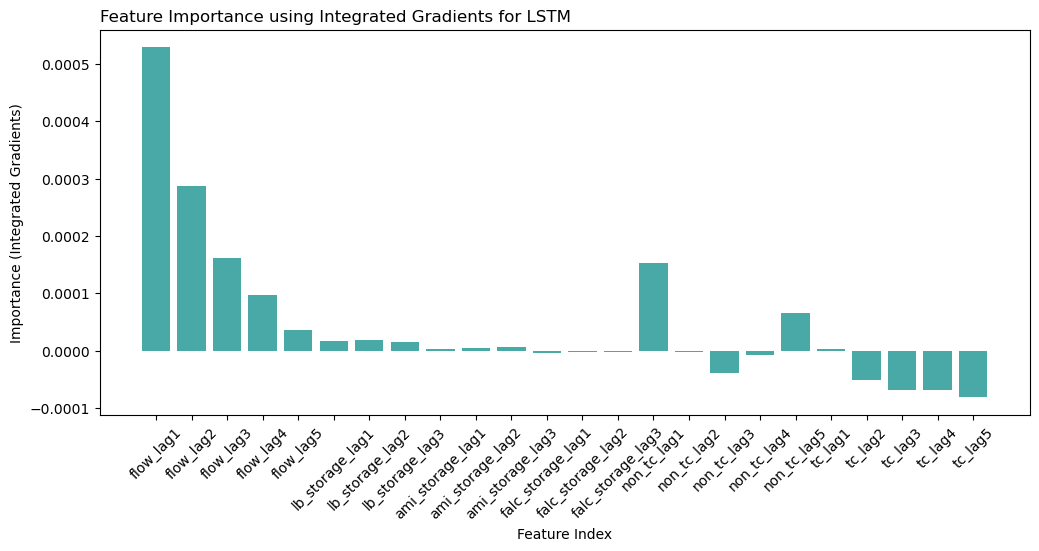

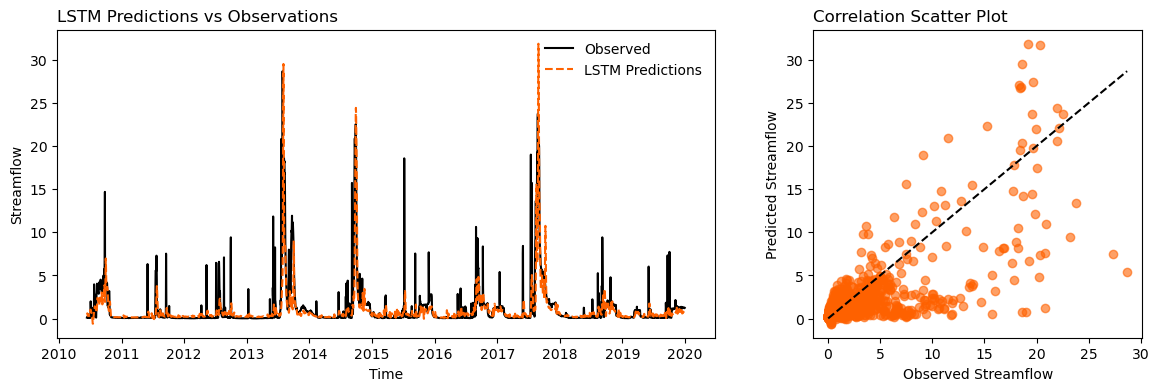

In [105]:
### LSTM
plot_integrated_grads(X_test_seq,features_lstm,lstm_model,'LSTM')
plot_predictions(y_test_denorm,lstm_preds,'LSTM',color=IBM_ORANGE)

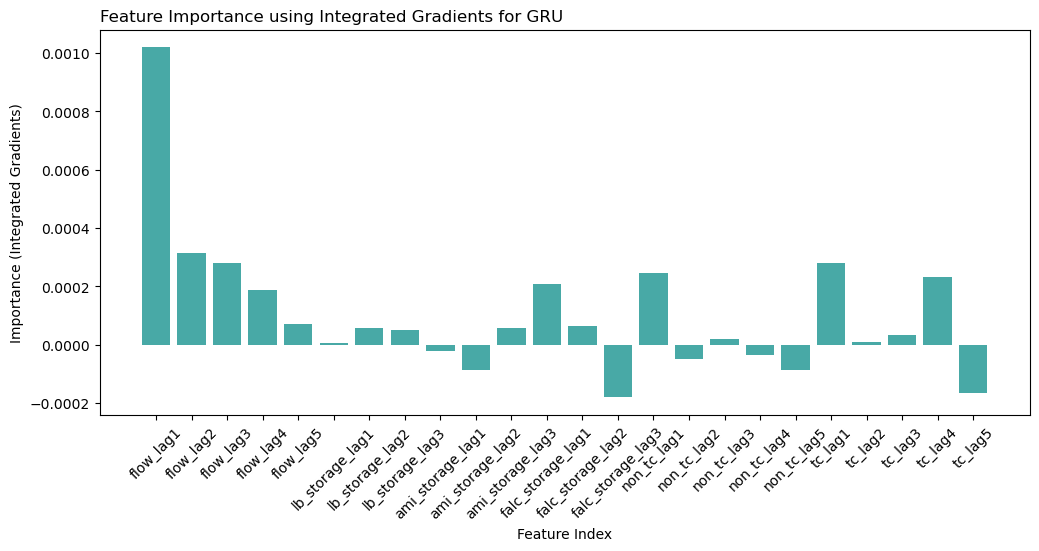

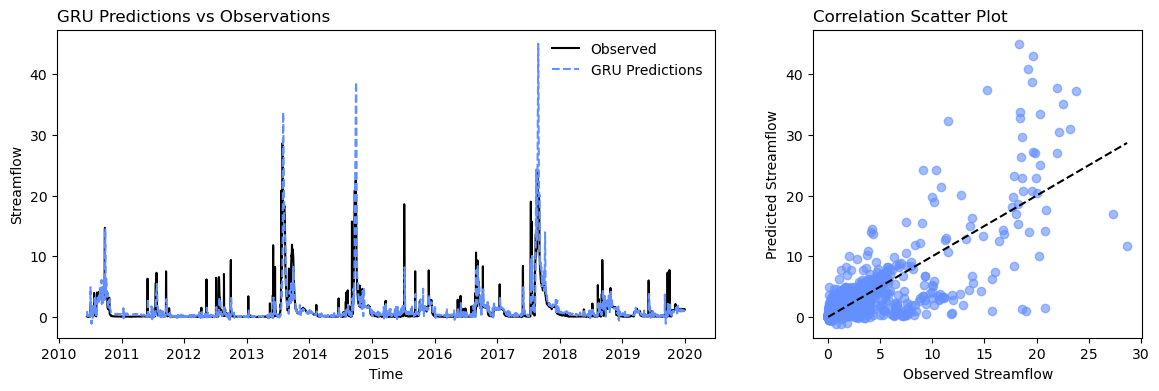

In [106]:
### GRU
plot_integrated_grads(X_test_seq,features_lstm,gru_model,'GRU')
plot_predictions(y_test_denorm_gru,gru_preds,'GRU',color=IBM_BLUE)

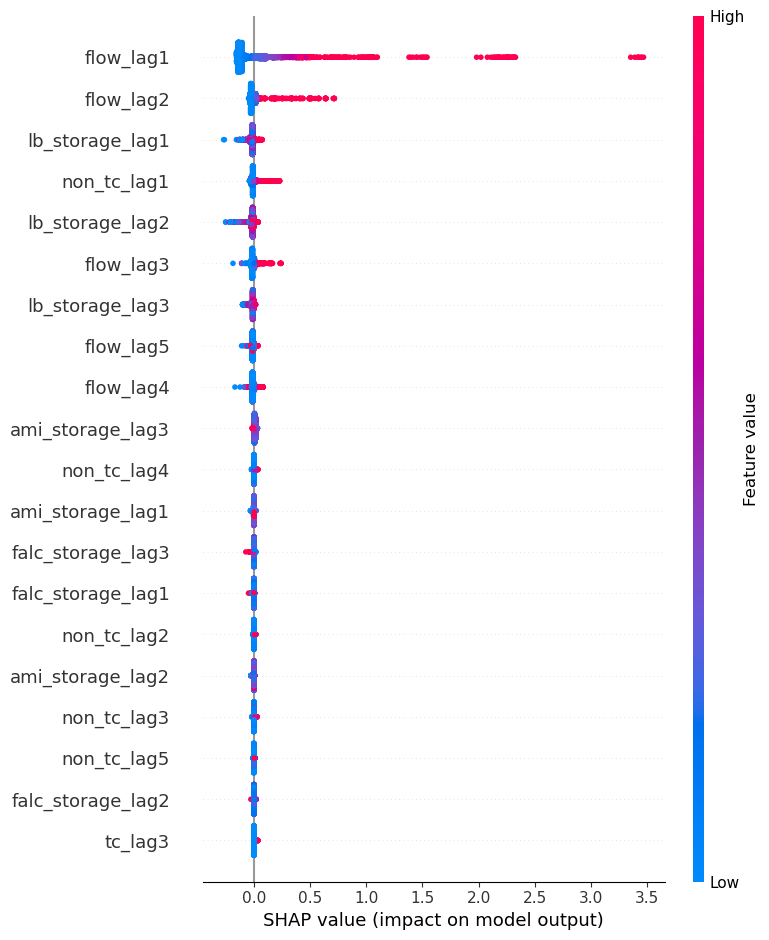

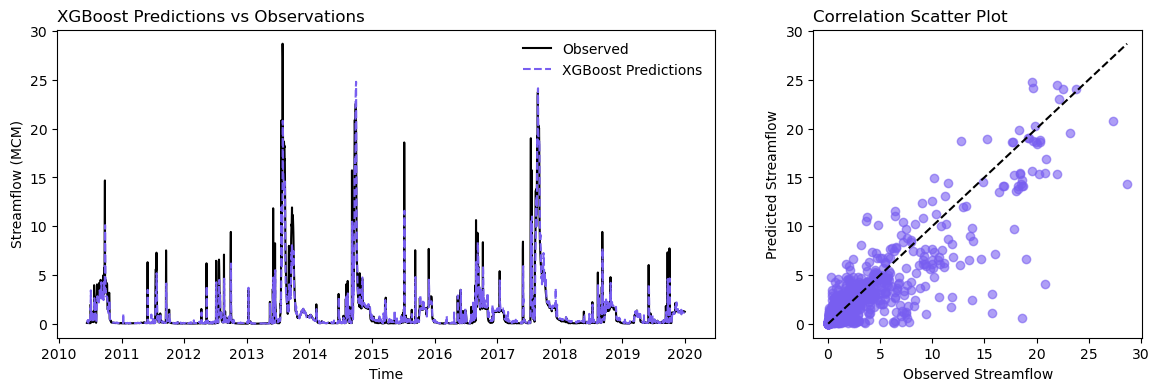

In [114]:
### XGBOOST
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test_xg)

# Summary plot with feature names
shap.summary_plot(shap_values, X_test_xg, feature_names=features_lstm)

plot_predictions(denorm_y_test_xg,best_xgb_preds,'XGBoost',color=IBM_PURPLE)

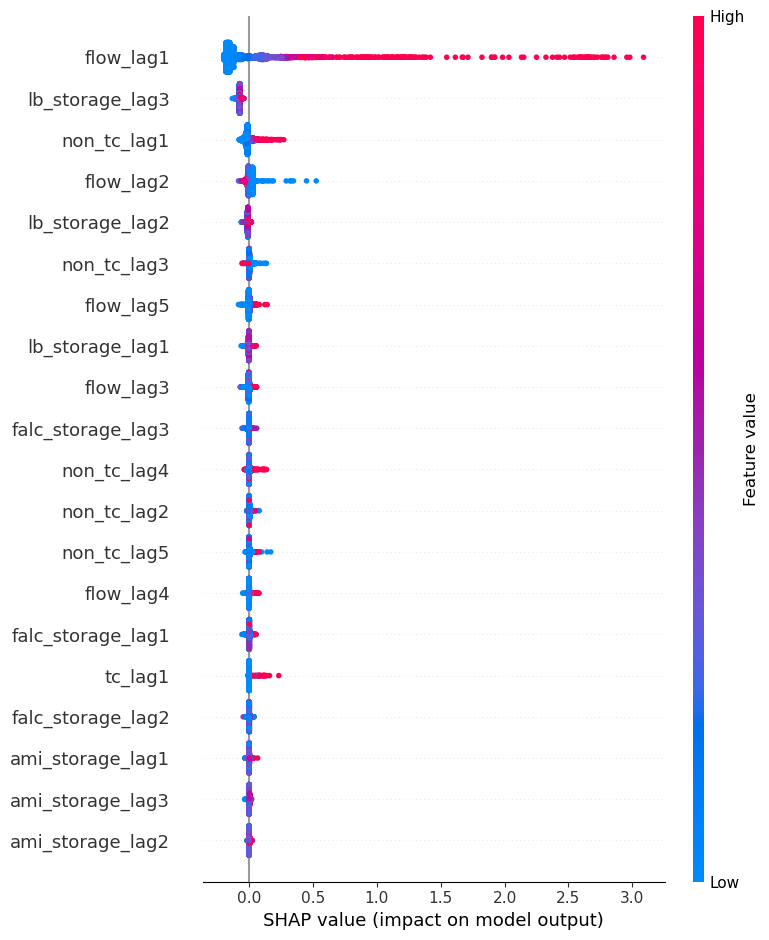

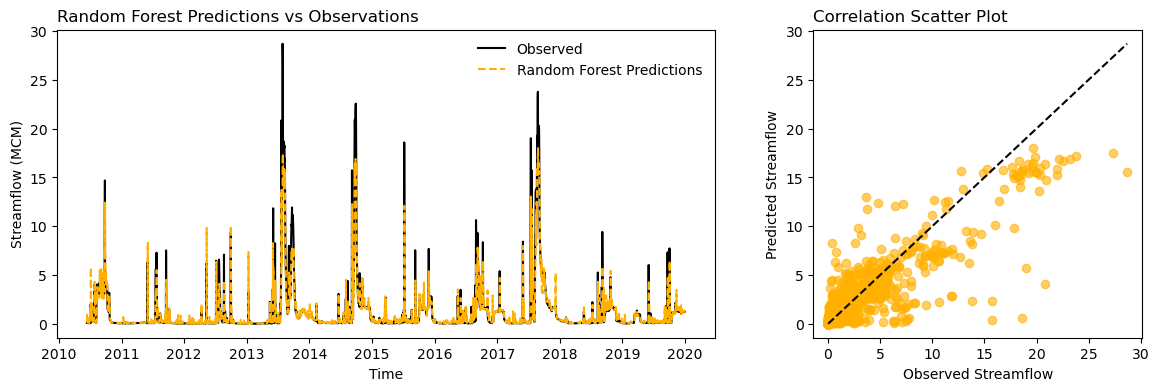

In [121]:
### RANDOM FOREST
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test_xg)

# Summary plot with feature names
shap.summary_plot(shap_values, X_test_xg, feature_names=features_lstm)

plot_predictions(rf_y_test,rf_predictions,'Random Forest',color=IBM_YELLOW)

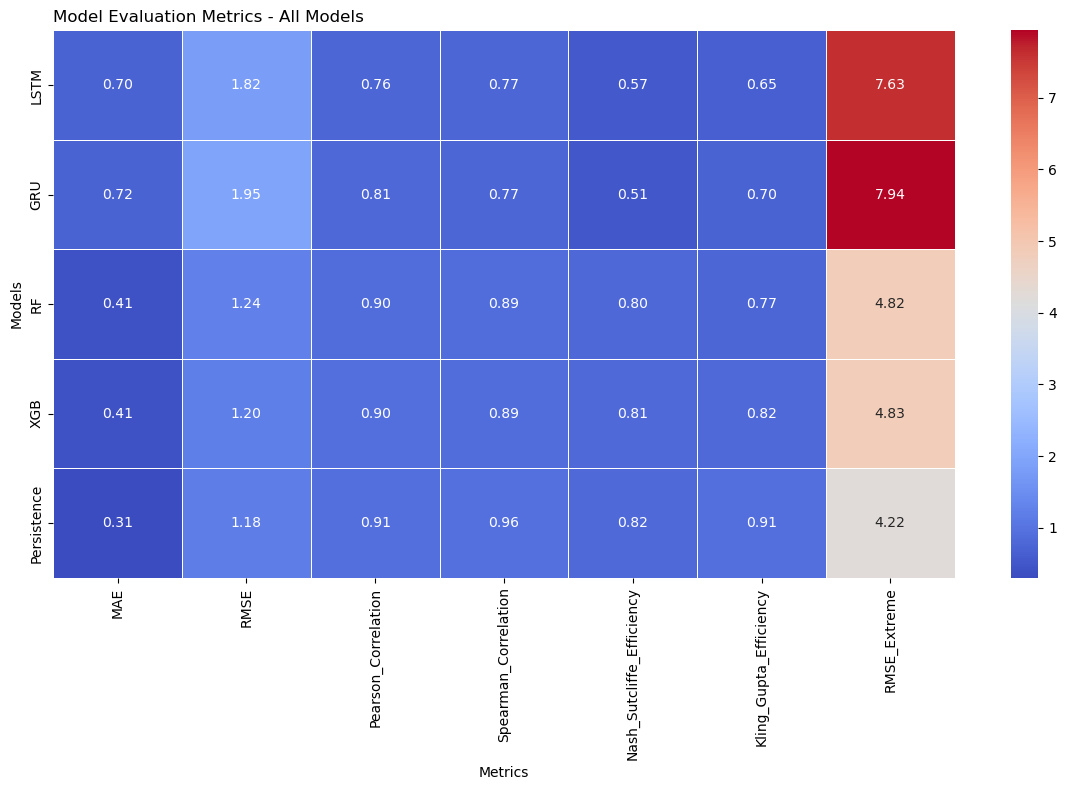

In [120]:
model_metrics = [lstm_metrics, gru_metrics, rf_metrics, metrics_xgb, persistence_metrics]

# Define model names
model_names = ['LSTM', 'GRU', 'RF', 'XGB', 'Persistence']

# Create a DataFrame from the dictionaries
metrics_df = pd.DataFrame(model_metrics, index=model_names)

# Create a heatmap
#plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)

# Customize the plot
ax.set_title('Model Evaluation Metrics - All Models',loc='left')
ax.set_ylabel('Models')
ax.set_xlabel('Metrics')

# Show the plot
fig.tight_layout()

### EXTRA

In [398]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define the parameter grid to search, including the `alpha` for quantile regression
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.4, 1.0],
    'reg_lambda': [0.8, 1.0, 1.2],
    'objective': ['reg:quantileerror'],  # Quantile regression objective
    'quantile_alpha': [0.7,0.9,0.95,0.99]  # Quantile parameter (0.9 for 90th percentile, change as needed)
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor()

# Set up RandomizedSearchCV with the parameter grid
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model to the training data
random_search.fit(X_train_xg, y_train_xg)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the final model with the best hyperparameters
best_xgb_model = random_search.best_estimator_

# Evaluate the final model (assuming train_evaluate_xgboost_model is defined)
xgb_model, best_xgb_preds, denorm_y_test_xg, metrics_xgb = train_evaluate_xgboost_model(
    best_xgb_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
)

# Print the metrics
for metric, value in metrics_xgb.items():
    print(f"{metric}: {value}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 1.2, 'reg_alpha': 1.0, 'quantile_alpha': 0.9, 'objective': 'reg:quantileerror', 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
[0]	validation_0-quantile:0.07389
[1]	validation_0-quantile:0.06954
[2]	validation_0-quantile:0.06338
[3]	validation_0-quantile:0.05785
[4]	validation_0-quantile:0.05362
[5]	validation_0-quantile:0.04936
[6]	validation_0-quantile:0.04525
[7]	validation_0-quantile:0.04013
[8]	validation_0-quantile:0.03585
[9]	validation_0-quantile:0.03525
[10]	validation_0-quantile:0.03483
[11]	validation_0-quantile:0.03470
[12]	validation_0-quantile:0.03457
[13]	validation_0-quantile:0.03453
[14]	validation_0-quantile:0.03439
[15]	validation_0-quantile:0.03428
[16]	validation_0-quantile:0.03410
[17]	validation_0-quantile:0.03395
[18]	validation_0-quantile:0.03383
[19]	validation_0-quantile:0.03364
[2

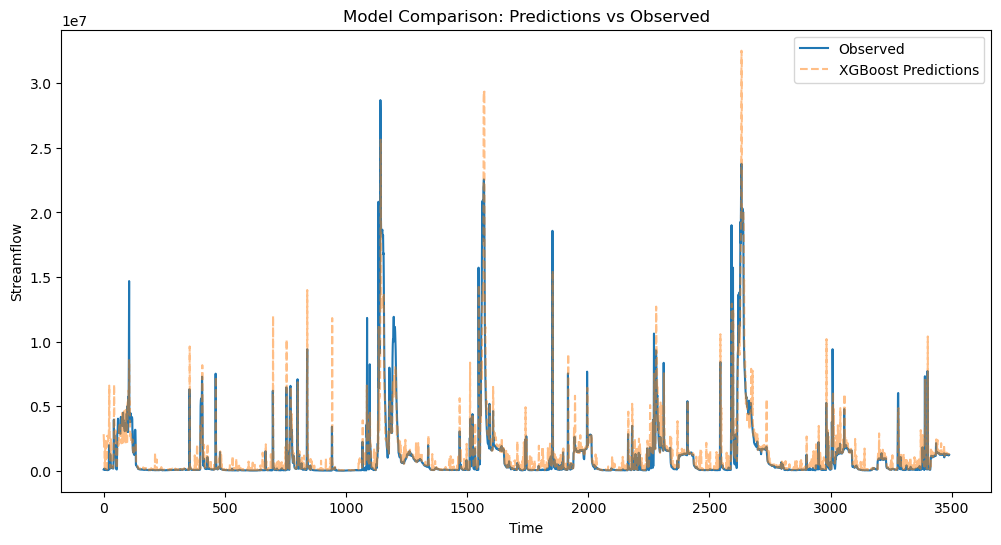

In [401]:
### Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='Observed')
#plt.plot(lstm_preds, label='LSTM Predictions', linestyle='--')
plt.plot(best_xgb_preds, label='XGBoost Predictions', linestyle='--',alpha=0.5)
#plt.plot(gru_preds, label='GRU Predictions', linestyle='--')
#plt.plot(persistence_preds, label='Persistence Predictions', linestyle='-')
plt.legend()
plt.title('Model Comparison: Predictions vs Observed')
plt.ylabel('Streamflow')
plt.xlabel('Time')
plt.show()

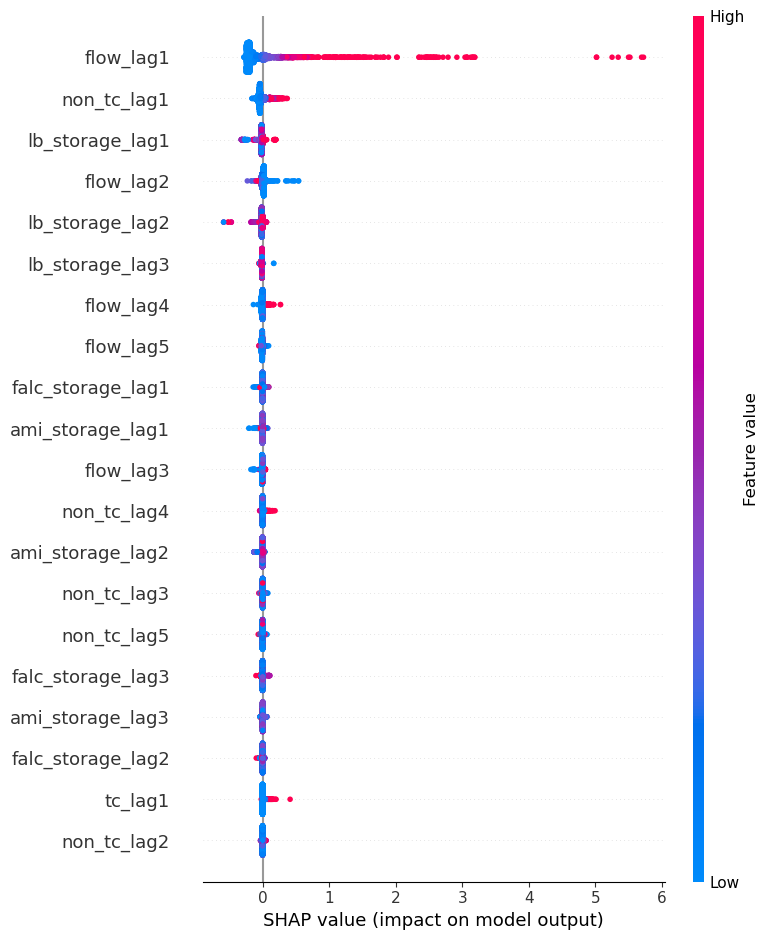

In [402]:
import shap
# Use the SHAP explainer
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test_xg)

# Summary plot with feature names
shap.summary_plot(shap_values, X_test_xg, feature_names=features_lstm)

# Force plot for an individual prediction (adjust the index for a specific instance)
instance_index = 1050
shap.force_plot(explainer.expected_value, shap_values.values[instance_index], X_test_xg[instance_index], feature_names=features_lstm)

In [407]:
print(f'lstm_metrics: {lstm_metrics}')
print(f'gru_metrics: {gru_metrics}')
print(f'rf_metrics: {rf_metrics}')
print(f'metrics_xgb: {metrics_xgb}')
print(f'persistence_metrics: {persistence_metrics}')

lstm_metrics: {'MAE': 706386.2114906877, 'RMSE': 1784048.4389406382, 'Pearson_Correlation': 0.7795205078593276, 'Spearman_Correlation': 0.7385903346688286, 'Nash_Sutcliffe_Efficiency': 0.5872534965691734, 'Kling_Gupta_Efficiency': 0.6250103636568036, 'RMSE_Extreme': 7277674.594059642}
gru_metrics: {'MAE': 792628.8532041546, 'RMSE': 1874667.106319894, 'Pearson_Correlation': 0.8000656699425824, 'Spearman_Correlation': 0.7677284601360469, 'Nash_Sutcliffe_Efficiency': 0.5442586467660218, 'Kling_Gupta_Efficiency': 0.7115348311486178, 'RMSE_Extreme': 6787947.605253144}
rf_metrics: {'MAE': 407707.6995767738, 'RMSE': 1250038.658438315, 'Pearson_Correlation': 0.8994524830695838, 'Spearman_Correlation': 0.8940318684754288, 'Nash_Sutcliffe_Efficiency': 0.7973638117191015, 'Kling_Gupta_Efficiency': 0.7633119512223567, 'RMSE_Extreme': 4864084.649765655}
metrics_xgb: {'MAE': 569534.4924061605, 'RMSE': 1414932.66934115, 'Pearson_Correlation': 0.8645848804428959, 'Spearman_Correlation': 0.840733300648

In [124]:
rf_predictions.shape

(3490,)

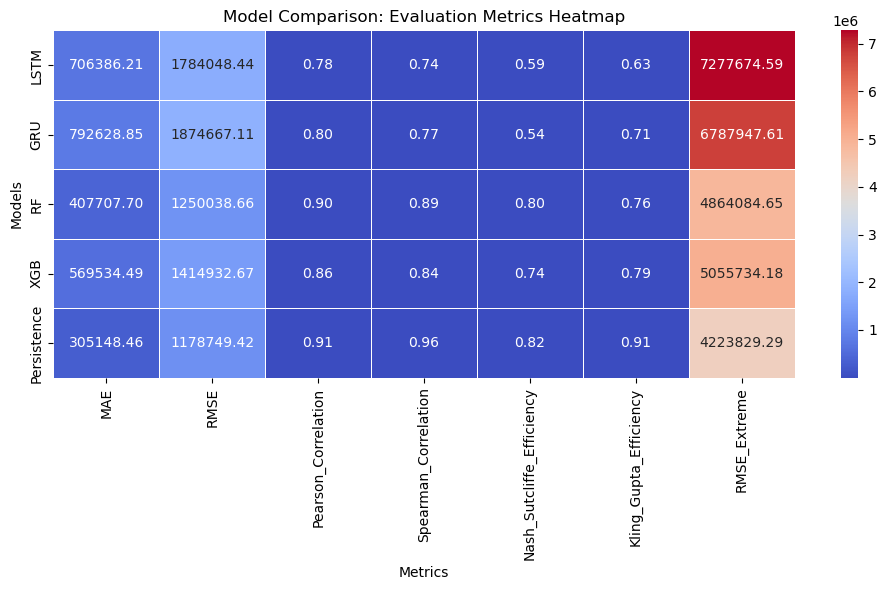

In [432]:
import seaborn as sns
model_metrics = [lstm_metrics, gru_metrics, rf_metrics, metrics_xgb, persistence_metrics]

# Define model names
model_names = ['LSTM', 'GRU', 'RF', 'XGB', 'Persistence']

# Create a DataFrame from the dictionaries
metrics_df = pd.DataFrame(model_metrics, index=model_names)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)

# Customize the plot
plt.title('Model Comparison: Evaluation Metrics Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')

# Show the plot
plt.tight_layout()

In [129]:
dates_dict_xg['test_dates'].values[0]

numpy.datetime64('2010-06-12T00:00:00.000000000')